Begun 2/28/24

Having confirmed that w2 is the correct correction (as long as the map isn't too small) in healpy_only_mask_test_20240215.ipynb, this notebook aims to correct a few errors and test the regular EB miscalibration angle estimator against mine.

The things that are fixed:
- Corrected the coordinate system in how I rotate the Q/U maps to get rid of the spurious factor of -2
- Healpy expects spectra to begin at ell=0, but I was passing in CAMB spectra starting at ell=2. I am now making my spectra all start at ell=0 so that things are consistent.
- Not really a fix, but also added in the EB miscalibration estimator to test against mine

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [3]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [11]:
# Making healpy sim of unrotated map
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))
unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
print(unrot_sim_maps.shape)
CMB_Q = unrot_sim_maps[1]
CMB_U = unrot_sim_maps[2]

6.870972823634812
(3, 3145728)


In [16]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    return fit_values

In [13]:
def get_pixels(nside, dec, ra):
    npix = int(nside)**2*12
    allpix = np.arange(npix)
    alldec = hp.pix2ang(nside, allpix)[0]
    allRA = hp.pix2ang(nside, allpix)[1]
    cross0 = 0
    if 0 > np.min(ra) and np.max(ra) > 0:
        print("RA crossing 0")
        cross0 = 1
    dec_lim = np.radians(np.array([dec[0], dec[1]])*(-1.0) + 90.0)
    RA_lim = np.radians(np.array([ra[0], ra[1]]))
    if cross0:
        keep1 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > 0))[0] 
        keep2 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA - 2 * np.pi > RA_lim[0]) & (allRA - 2 * np.pi < 0))[0]
        keep = np.append(np.array(keep1), np.array(keep2))
    else:
        keep = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > RA_lim[0]))[0] 
    return keep


def eq_to_gal(nside, pix):
    lat, lon = hp.pix2ang(nside, pix)
    r = hp.Rotator(coord=['C','G'])
    lat, lon = r(lat, lon)
    temp = hp.ang2pix(nside, lat, lon)
    temp = list(set(temp))
    try:
        assert len(pix) == len(temp)
    except AssertionError:
        print("lost %i pixels out of %i pixels"%(len(pix)-len(temp),len(pix)))
    return temp


def fill_missing_pix(nside, pix, nside_out):
    testmap = np.zeros(nside ** 2 * 12)
    testmap[pix] = 1
    # hp.mollview(testmap)
    # plt.show()
    # exit()
    testmap[testmap == 0] = -0.01
    testmap = hp.smoothing(testmap, sigma = np.radians(0.1), iter = 1)
    testmap[testmap < 0] = 0
    testmap[testmap != 0] = 1
    return hp.ud_grade(testmap, nside_out)

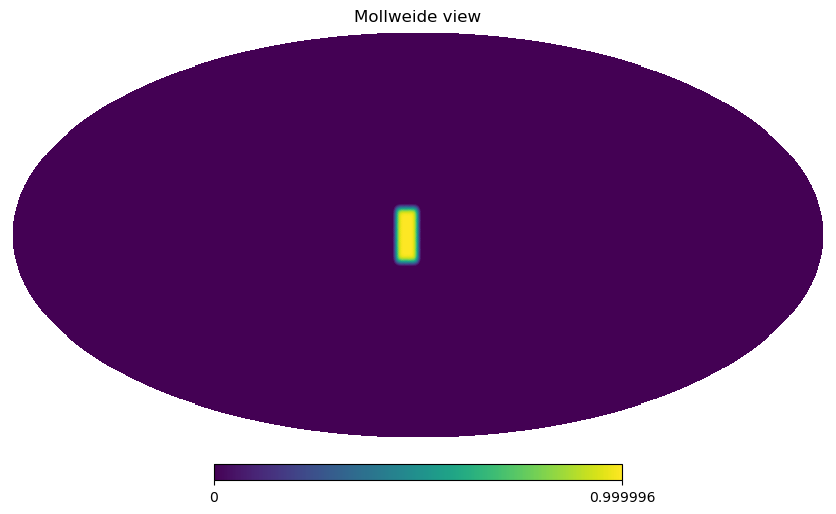

In [14]:
# Example mask
ra = [0,10]
dec = [10,-10]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [17]:
# Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []
output_null_eb_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    print("Output null EB angle: " + str(null_eb_fit_values))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Recovered angles: ")
print(output_angles_only)
print("Percent difference: ")
print(100.0*(output_angles_only - rot_degs)/rot_degs)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only)
print("Percent difference: ")
print(100.0*(output_null_eb_angles_only - rot_degs)/rot_degs)

Input angles are: [-8.08844721 -1.07131519 -0.06553149 -2.00500598 -0.12540866  2.87746575
  0.85402984 -0.81248309 -3.46133997  5.07135505]
Output angle: (-7.79764968471323, 0.37637431210299443)
Output null EB angle: (-7.66095438926047, 0.4092140423173576)
Output angle: (-1.033493512093984, 0.048670031016338294)
Output null EB angle: (-0.9965591916029142, 0.07959942743348776)
Output angle: (-0.06321871355291041, 0.0029758592440068603)
Output null EB angle: (-0.03927309467091261, 0.06256878724337267)
Output angle: (-1.934163966413231, 0.09118381197612555)
Output null EB angle: (-1.8855902185243882, 0.11130266967289351)
Output angle: (-0.12098265379377342, 0.005694973515794739)
Output null EB angle: (-0.09632790958624546, 0.06272374334185168)
Output angle: (2.775675234521206, 0.13106667988177712)
Output null EB angle: (2.771474471629317, 0.1487529357268051)
Output angle: (0.8238827554373299, 0.03879277072297666)
Output null EB angle: (0.838065627098979, 0.07506814074966443)
Output angle

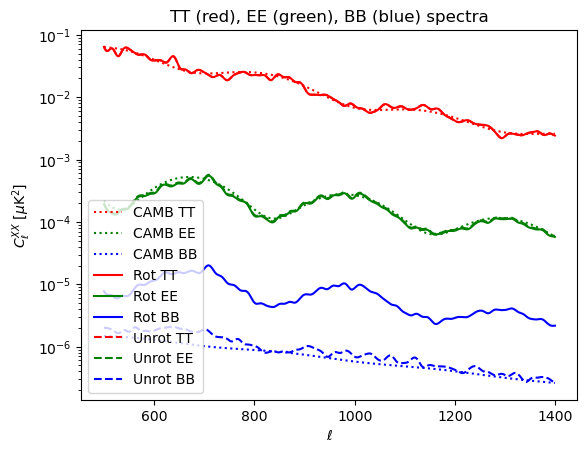

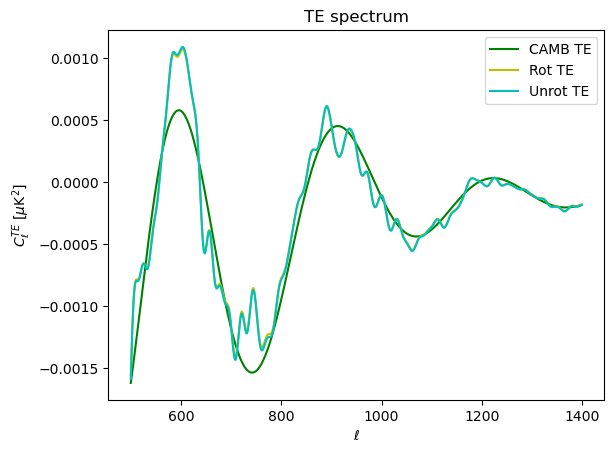

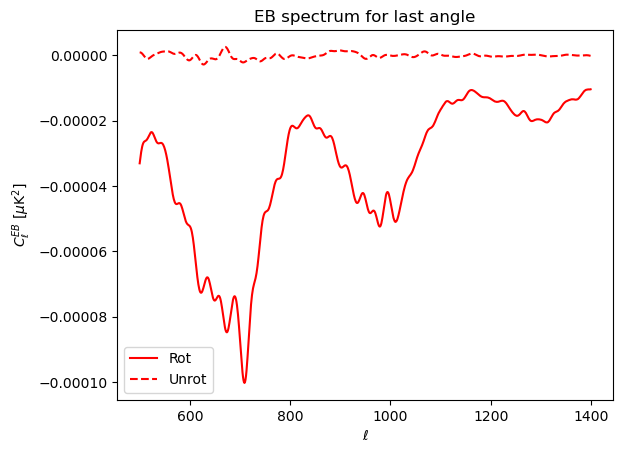

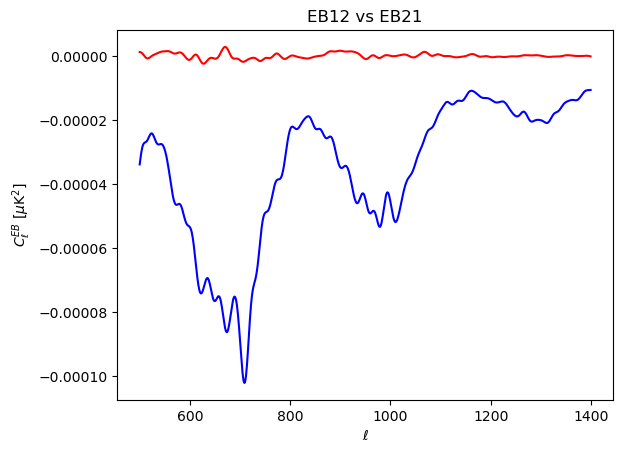

In [18]:
plt.semilogy(ell_hp,ClTT[min_ell:max_ell],'r:',label='CAMB TT')
plt.semilogy(ell_hp,ClEE[min_ell:max_ell],'g:',label='CAMB EE')
plt.semilogy(ell_hp,ClBB[min_ell:max_ell],'b:',label='CAMB BB')
plt.semilogy(ell_hp,ClTT_rot,'r',label='Rot TT')
plt.semilogy(ell_hp,ClEE_rot,'g',label='Rot EE')
plt.semilogy(ell_hp,ClBB_rot,'b',label='Rot BB')
plt.semilogy(ell_hp,ClTT_unrot,'r--',label='Unrot TT')
plt.semilogy(ell_hp,ClEE_unrot,'g--',label='Unrot EE')
plt.semilogy(ell_hp,ClBB_unrot,'b--',label='Unrot BB')
plt.title('TT (red), EE (green), BB (blue) spectra')
plt.ylabel('$C^{XX}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

plt.plot(ell_hp,ClTE[min_ell-2:max_ell-2],'g',label='CAMB TE')
plt.plot(ell_hp,ClTE_rot,'y',label='Rot TE')
plt.plot(ell_hp,ClTE_unrot,'c',label='Unrot TE')
plt.ylabel('$C^{TE}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('TE spectrum')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_rot,'r',label='Rot')
plt.plot(ell_hp,ClEB_unrot,'r--',label='Unrot')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB spectrum for last angle')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_cross12,'r')
plt.plot(ell_hp,ClEB_cross21,'b')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB12 vs EB21')
plt.show()

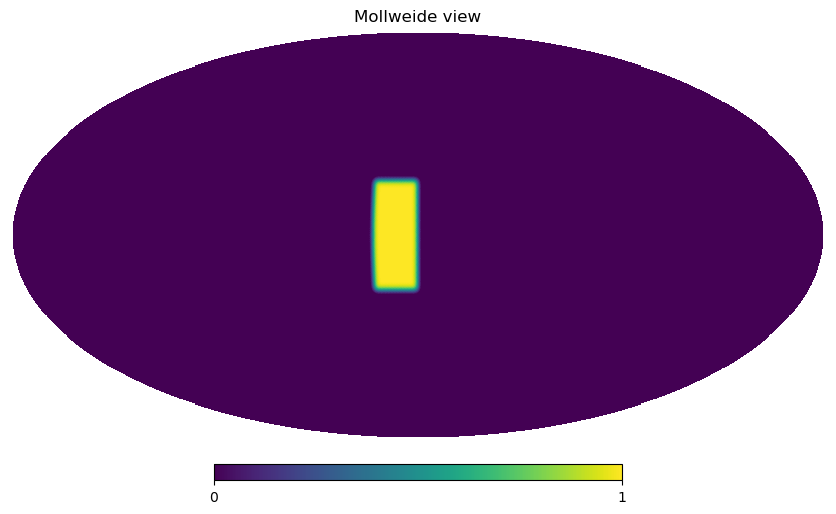

In [19]:
# Testing larger mask
ra = [0,20]
dec = [20,-20]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [20]:
# Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []
output_null_eb_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

#rot_degs = np.random.normal(0, 5, size=(10)) # Using same angles as last time for consistency
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    print("Output null EB angle: " + str(null_eb_fit_values))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Recovered angles: ")
print(output_angles_only)
print("Percent difference: ")
print(100.0*(output_angles_only - rot_degs)/rot_degs)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only)
print("Percent difference: ")
print(100.0*(output_null_eb_angles_only - rot_degs)/rot_degs)

Input angles are: [-8.08844721 -1.07131519 -0.06553149 -2.00500598 -0.12540866  2.87746575
  0.85402984 -0.81248309 -3.46133997  5.07135505]
Output angle: (-8.04077734077734, 0.3882864020046403)
Output null EB angle: (-7.962064557462888, 0.4273951998940279)
Output angle: (-1.0648768681630474, 0.05009092957779977)
Output null EB angle: (-1.0563672597848035, 0.07949349170216388)
Output angle: (-0.06513754628817447, 0.0030626150522274818)
Output null EB angle: (-0.06817824806494001, 0.05998655521088896)
Output angle: (-1.992965458651878, 0.09385537898863304)
Output null EB angle: (-1.9750205451965932, 0.11350982232730342)
Output angle: (-0.12465477131916856, 0.005861002547063006)
Output null EB angle: (-0.12696330091053082, 0.0602292524000634)
Output angle: (2.860205437923117, 0.1349271309690418)
Output null EB angle: (2.8295847942278445, 0.15025169362623048)
Output angle: (0.8488967926311364, 0.03992472035718858)
Output null EB angle: (0.8357410330418005, 0.07286209095463654)
Output angl

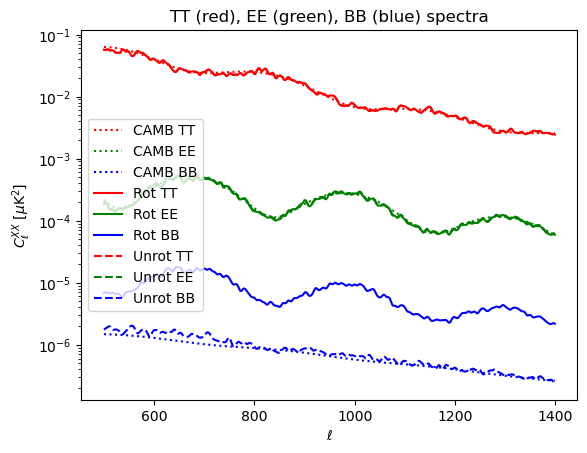

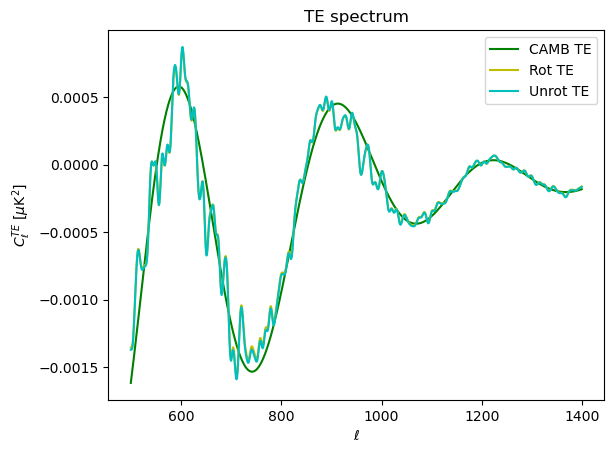

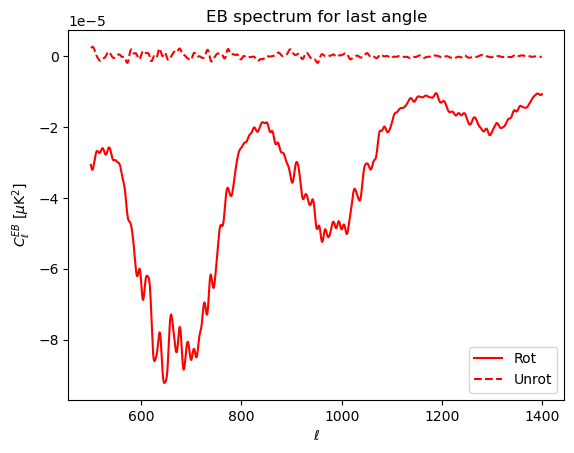

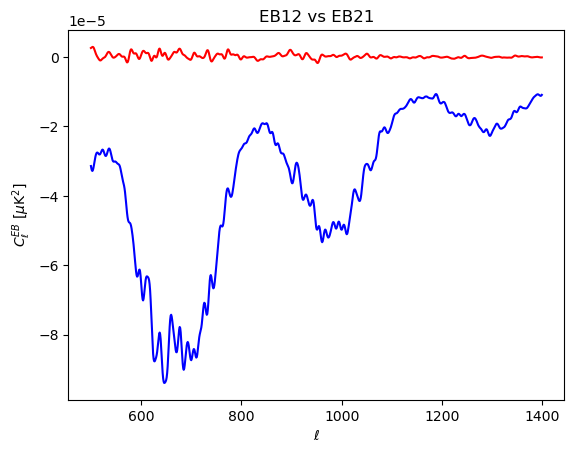

In [21]:
plt.semilogy(ell_hp,ClTT[min_ell:max_ell],'r:',label='CAMB TT')
plt.semilogy(ell_hp,ClEE[min_ell:max_ell],'g:',label='CAMB EE')
plt.semilogy(ell_hp,ClBB[min_ell:max_ell],'b:',label='CAMB BB')
plt.semilogy(ell_hp,ClTT_rot,'r',label='Rot TT')
plt.semilogy(ell_hp,ClEE_rot,'g',label='Rot EE')
plt.semilogy(ell_hp,ClBB_rot,'b',label='Rot BB')
plt.semilogy(ell_hp,ClTT_unrot,'r--',label='Unrot TT')
plt.semilogy(ell_hp,ClEE_unrot,'g--',label='Unrot EE')
plt.semilogy(ell_hp,ClBB_unrot,'b--',label='Unrot BB')
plt.title('TT (red), EE (green), BB (blue) spectra')
plt.ylabel('$C^{XX}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

plt.plot(ell_hp,ClTE[min_ell-2:max_ell-2],'g',label='CAMB TE')
plt.plot(ell_hp,ClTE_rot,'y',label='Rot TE')
plt.plot(ell_hp,ClTE_unrot,'c',label='Unrot TE')
plt.ylabel('$C^{TE}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('TE spectrum')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_rot,'r',label='Rot')
plt.plot(ell_hp,ClEB_unrot,'r--',label='Unrot')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB spectrum for last angle')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_cross12,'r')
plt.plot(ell_hp,ClEB_cross21,'b')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB12 vs EB21')
plt.show()

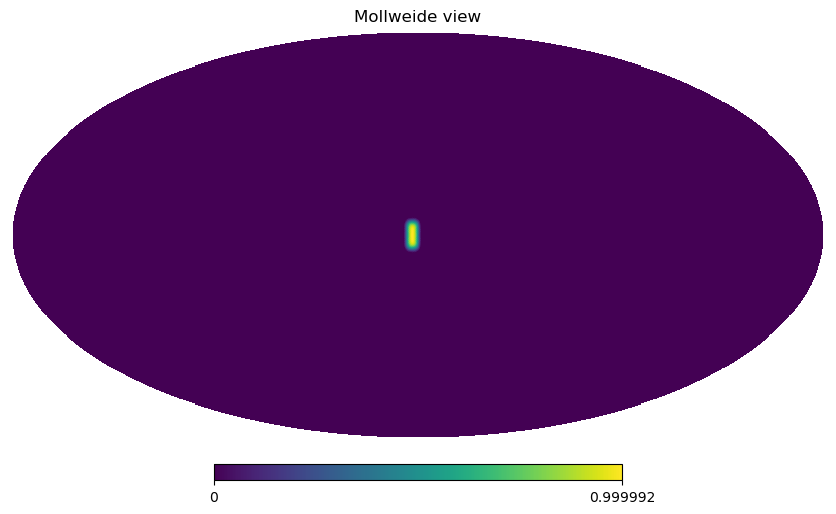

In [22]:
# Testing smaller mask
ra = [0,5]
dec = [5,-5]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [23]:
# Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []
output_null_eb_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

#rot_degs = np.random.normal(0, 5, size=(10)) # Using same angles as last time for consistency
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    print("Output null EB angle: " + str(null_eb_fit_values))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Recovered angles: ")
print(output_angles_only)
print("Percent difference: ")
print(100.0*(output_angles_only - rot_degs)/rot_degs)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only)
print("Percent difference: ")
print(100.0*(output_null_eb_angles_only - rot_degs)/rot_degs)

Input angles are: [-8.08844721 -1.07131519 -0.06553149 -2.00500598 -0.12540866  2.87746575
  0.85402984 -0.81248309 -3.46133997  5.07135505]
Output angle: (-8.04576560046836, 0.39104991026649577)
Output null EB angle: (-7.887523469221372, 0.4286431323324218)
Output angle: (-1.0655161984704817, 0.050444787661411125)
Output null EB angle: (-0.9902343837140875, 0.08628557668877308)
Output angle: (-0.06517663135565223, 0.003084247643815874)
Output null EB angle: (-0.003344854245692738, 0.07083147828073635)
Output angle: (-1.994163703853859, 0.09451861044732994)
Output null EB angle: (-1.91199837118577, 0.11801400278466065)
Output angle: (-0.12472956946641711, 0.005902401426574457)
Output null EB angle: (-0.06176926187925141, 0.07087221827943094)
Output angle: (2.861928755382765, 0.13588104282880376)
Output null EB angle: (2.8788473718358976, 0.15890301293420656)
Output angle: (0.8494063470878223, 0.04020674832694259)
Output null EB angle: (0.8949508641698144, 0.08421603834328076)
Output an

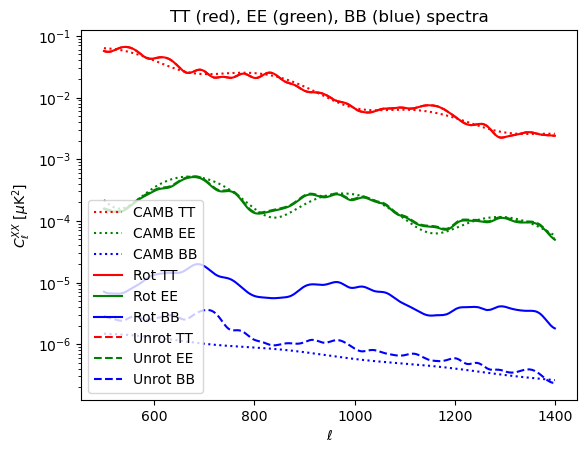

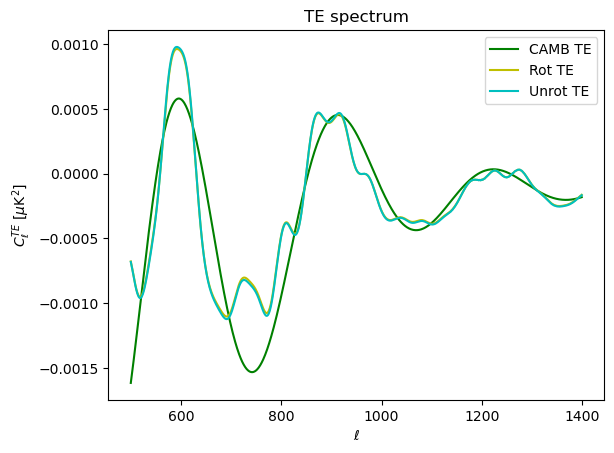

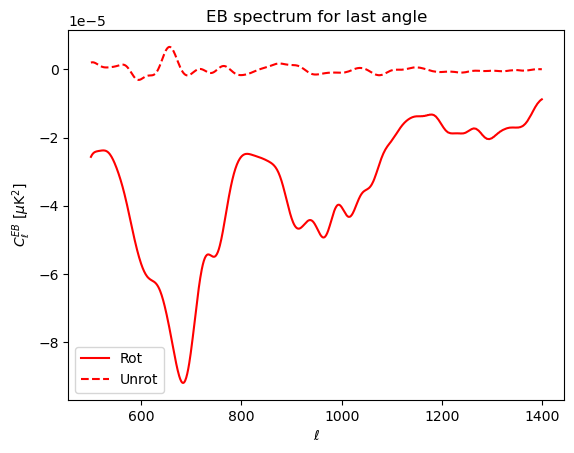

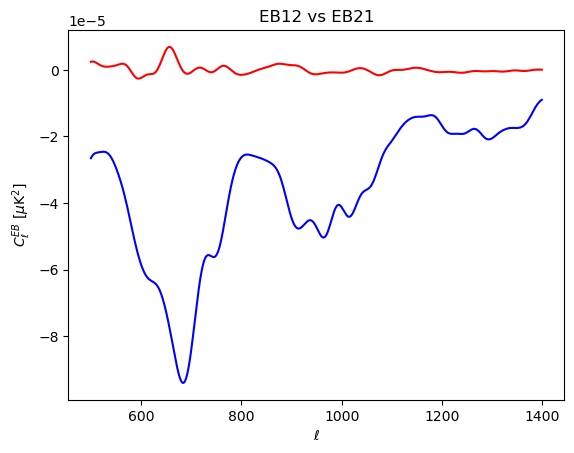

In [24]:
plt.semilogy(ell_hp,ClTT[min_ell:max_ell],'r:',label='CAMB TT')
plt.semilogy(ell_hp,ClEE[min_ell:max_ell],'g:',label='CAMB EE')
plt.semilogy(ell_hp,ClBB[min_ell:max_ell],'b:',label='CAMB BB')
plt.semilogy(ell_hp,ClTT_rot,'r',label='Rot TT')
plt.semilogy(ell_hp,ClEE_rot,'g',label='Rot EE')
plt.semilogy(ell_hp,ClBB_rot,'b',label='Rot BB')
plt.semilogy(ell_hp,ClTT_unrot,'r--',label='Unrot TT')
plt.semilogy(ell_hp,ClEE_unrot,'g--',label='Unrot EE')
plt.semilogy(ell_hp,ClBB_unrot,'b--',label='Unrot BB')
plt.title('TT (red), EE (green), BB (blue) spectra')
plt.ylabel('$C^{XX}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()


plt.plot(ell_hp,ClTE[min_ell-2:max_ell-2],'g',label='CAMB TE')
plt.plot(ell_hp,ClTE_rot,'y',label='Rot TE')
plt.plot(ell_hp,ClTE_unrot,'c',label='Unrot TE')
plt.ylabel('$C^{TE}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('TE spectrum')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_rot,'r',label='Rot')
plt.plot(ell_hp,ClEB_unrot,'r--',label='Unrot')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB spectrum for last angle')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_cross12,'r')
plt.plot(ell_hp,ClEB_cross21,'b')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB12 vs EB21')
plt.show()

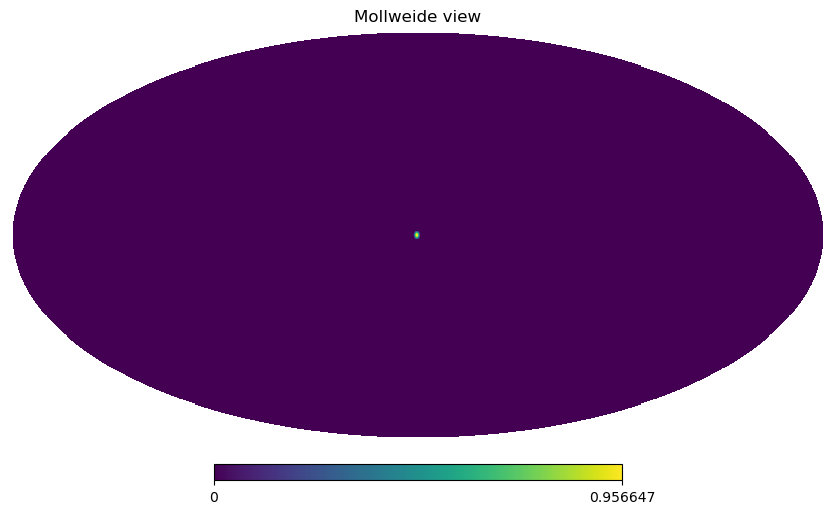

In [25]:
# Testing even smaller mask
ra = [0,1]
dec = [1,-1]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [26]:
# Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []
output_null_eb_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

#rot_degs = np.random.normal(0, 5, size=(10)) # Using same angles as last time for consistency
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    print("Output null EB angle: " + str(null_eb_fit_values))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Recovered angles: ")
print(output_angles_only)
print("Percent difference: ")
print(100.0*(output_angles_only - rot_degs)/rot_degs)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only)
print("Percent difference: ")
print(100.0*(output_null_eb_angles_only - rot_degs)/rot_degs)

Input angles are: [-8.08844721 -1.07131519 -0.06553149 -2.00500598 -0.12540866  2.87746575
  0.85402984 -0.81248309 -3.46133997  5.07135505]
Output angle: (-6.549575131197542, 0.3254746944809028)
Output null EB angle: (-6.150973819541915, 0.36005263861390163)
Output angle: (-0.871252006423487, 0.04255417898862435)
Output null EB angle: (-0.9223756364990197, 0.12765539358884923)
Output angle: (-0.053297800515212115, 0.0026024042762249765)
Output null EB angle: (-0.15313065151140698, 0.11700247518029105)
Output angle: (-1.630271387459646, 0.07968790213568044)
Output null EB angle: (-1.6334374461356584, 0.1474067219864384)
Output angle: (-0.10199678054231967, 0.00498027437703862)
Output null EB angle: (-0.19879549409931555, 0.11723723952769387)
Output angle: (2.33900994477613, 0.11446170747047688)
Output null EB angle: (2.0802903123091543, 0.1627203209389257)
Output angle: (0.6945628470897822, 0.03392042841546126)
Output null EB angle: (0.5449607759283872, 0.12034247582038611)
Output angl

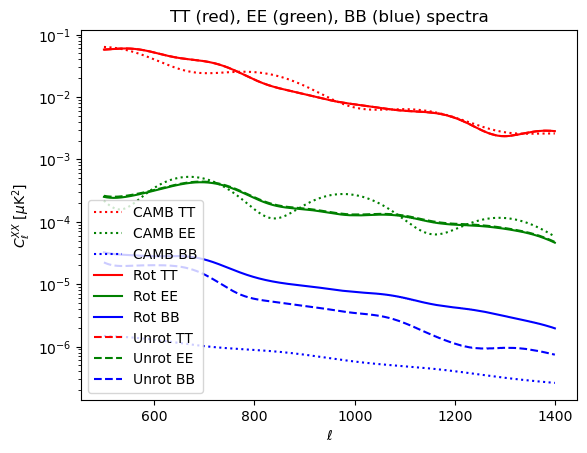

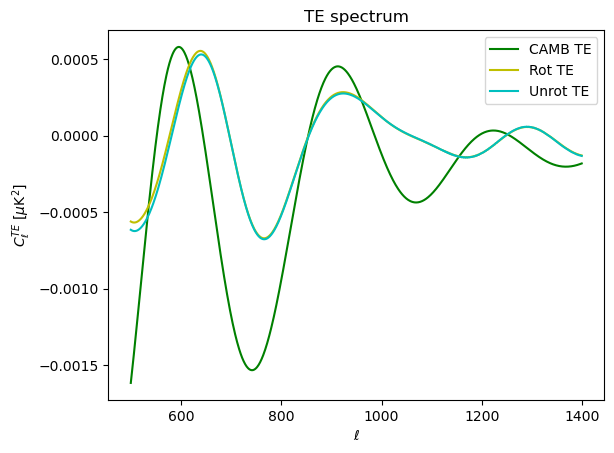

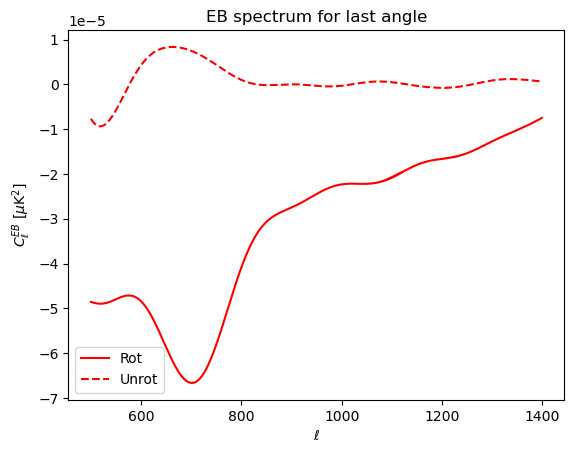

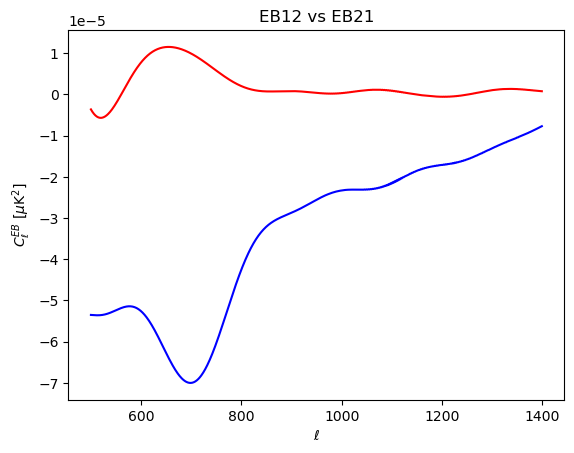

In [27]:
plt.semilogy(ell_hp,ClTT[min_ell:max_ell],'r:',label='CAMB TT')
plt.semilogy(ell_hp,ClEE[min_ell:max_ell],'g:',label='CAMB EE')
plt.semilogy(ell_hp,ClBB[min_ell:max_ell],'b:',label='CAMB BB')
plt.semilogy(ell_hp,ClTT_rot,'r',label='Rot TT')
plt.semilogy(ell_hp,ClEE_rot,'g',label='Rot EE')
plt.semilogy(ell_hp,ClBB_rot,'b',label='Rot BB')
plt.semilogy(ell_hp,ClTT_unrot,'r--',label='Unrot TT')
plt.semilogy(ell_hp,ClEE_unrot,'g--',label='Unrot EE')
plt.semilogy(ell_hp,ClBB_unrot,'b--',label='Unrot BB')
plt.title('TT (red), EE (green), BB (blue) spectra')
plt.ylabel('$C^{XX}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

plt.plot(ell_hp,ClTE[min_ell-2:max_ell-2],'g',label='CAMB TE')
plt.plot(ell_hp,ClTE_rot,'y',label='Rot TE')
plt.plot(ell_hp,ClTE_unrot,'c',label='Unrot TE')
plt.ylabel('$C^{TE}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('TE spectrum')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_rot,'r',label='Rot')
plt.plot(ell_hp,ClEB_unrot,'r--',label='Unrot')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB spectrum for last angle')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_cross12,'r')
plt.plot(ell_hp,ClEB_cross21,'b')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB12 vs EB21')
plt.show()